# House Price Prediction - Comprehensive Data Science Project
### —— Data Science Project for Exploratory Data Analysis (EDA), Statistical Inference, Feature Engineering, and Machine Learning.

#### Dataset downloaded from Kaggle
[<span style='color:#1f77b4'>**House Prices - Advanced Regression Techniques**</span>](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

### Life cycle of the Project:
- Understand the Problem
- Exploratory Data Analysis (Part 1)
  - whole picture of the data
  - univariate analysis

- Exploratory Data Analysis (Part 2)
  - Variable Correlation/Dependency Analysis
  - inferential statistics with hypothesis testing

- Feature Engineering
- Feature Importance Analysis
- <span style='color:blue'>**Machine Learning Model Building, evaluation, and deployment**</span>

# Machine Learning Model Building Phase
**Use preprocessed data saved from Feature Engineering phase to train different types of models for house sale price prediction, implement hyperparameter tunning for each model.**  
- use **log-transformed** SalePrice as target variable
- split training and test (validation) data from data in train.csv
#### XGBRegressor models with xgboost
- use randomizedsearch and gridsearch for model hyperparameter tunning
- check training and test set score for each model
- residual plots
#### Neural Network models with tensorflow
- try different model structures for prediction
- check training and test set score for each model
- training loss history plots
- residual plots
#### create competition submission file for selected models to test the score

<a name="0"></a>
# Content Outline
- [1. Packages, Datasets, and Customized Functions](#1) 
  - [Packages](#1.1)
  - [Version Information](#1.2)
  - [Datasets](#1.3)
  - [Customized Functions](#1.4)
- [2. XGBRegressor Model](#2)
  - [2.1 General Hyperparameter Tunning](#2.1)
  - [2.2 More Focused Hyperparameter Tunning](#2.2)
- [3. Neural Network Model](#3)
  - [3.1 Model 1](#3.1)
  - [3.2 Model 2](#3.2)


<a name="1"></a>
# 1. Packages, Datasets, and Customized Functions
- [Packages](#1.1)
- [Version Information](#1.2)
- [Datasets](#1.3)
- [Customized Functions](#1.4)

<a name="1.1"></a>
### Packages

In [1]:
###### import modules ####################################
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats # for QQ plot
from matplotlib.offsetbox import AnchoredText # for text annotation in plt plots
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error

###### neural network modules #############
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import backend as K

import session_info
import warnings
import inspect
import json

# warnings.filterwarnings('ignore') ## ignore warnings
pd.pandas.set_option('display.max_columns',None) ## Display all the columns of the dataframe

<a name="1.2"></a>
### version information for all imported modules
- use `session_info` to output version information for modules loaded in the current session, Python, the OS, and the CPU.
- version information is provided to increase reproducibility

In [2]:
session_info.show(std_lib=True, html=False)

-----
inspect             NA
io                  NA
json                2.0.9
keras               2.10.0
matplotlib          3.6.2
numpy               1.23.4
pandas              1.5.1
scipy               1.9.3
seaborn             0.12.1
session_info        1.0.0
sklearn             1.1.3
tensorflow          2.10.0
warnings            NA
xgboost             1.7.1
-----
IPython             8.6.0
jupyter_client      7.4.5
jupyter_core        5.0.0
jupyterlab          3.5.0
notebook            6.5.2
-----
Python 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
Windows-10-10.0.22000-SP0
-----
Session information updated at 2022-11-14 12:05


<a name="1.3"></a>
### Datasets
- preprocessed datasets are created and saved as .csv files in **Feature Engineering** phase

In [3]:
###### import preprocessed datasets: train_processed.csv, test_processed.csv ####################
main_processed = pd.read_csv('datasets_processed/train_processed.csv')
test_processed = pd.read_csv('datasets_processed/test_processed.csv')

In [4]:
main_pro = main_processed.copy()
test_pro = test_processed.copy()

In [5]:
###### prepare training + test data for model training: only use main_pro ############################
X_main_pro, y_main_pro = main_pro.drop('SalePrice', axis=1), np.log(main_pro[['SalePrice']])

In [6]:
###### train_test_split ######################
X_train, X_test, y_train, y_test = train_test_split(X_main_pro, y_main_pro, test_size = 0.2, random_state = 0)

<a name="1.4"></a>
### Customized Functions

In [7]:
### function that displays model information after training
def display_model_info(model, mdl_str, score_metric, X_test = X_test, y_test = y_test):
    """
    Display model information after training.
    
    Params:
    --------
    model (model object)         : fitted  RandomizedSearchCV / GridSearchCV regression model
    mdl_str (str)                : string representation of the model
    score_metric (str)           : string representation of scoring metric
    X_test, y_test (pd.DataFrame): test data feature and target variable data frame
    
    Returns:
    --------
    text summary of fitted model:
      model name, scoring metric, best parameter, 
      number of features with non-zero feature importance value, 
      best score of grid/random search model on training data, score on test data
    
    """
    print('\nModel: {}'.format(mdl_str))
    print('Scoring Metric: {}'.format(score_metric))
    print('-' * 20)
    print('best parameter achieved by parameter-search model:\n')
    print(json.dumps(model.best_params_, indent=2, default=str))
    print(('\nnumber of features with non-zero feature importance value: {} out of {}'
           .format((model.best_estimator_.feature_importances_ != 0).sum(), X_test.shape[1])))
    print('\nbest {} score achieved by parameter-search model:{}'.format(score_metric, model.best_score_))
    print(('\nroot_mean_squared_error score on test set:{}'
           .format(mean_squared_error(y_test, model.predict(X_test), squared=False))))
    return

In [8]:
### function that creates multipule plots to check residuals
def plot_resid(model, mdl_str, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """
    Create plot matrix to check model residuals.
    
    Params:
    --------
    model (model object)           : fitted  RandomizedSearchCV / GridSearchCV regression model
    mdl_str (str)                  : string representation of the model
    X_train, y_train (pd.DataFrame): training data feature and target variable data frame
    X_test, y_test (pd.DataFrame)  : test data feature and target variable data frame
    
    Returns:
    --------
    plt figure:
      subplots include scatter plot, histogram & kde plot, and QQ-plot
    
    """
    fig, axs = plt.subplots(3, 2, figsize = (9, 10))
    axs = axs.flatten()
    plt.sca(axs[0])
    plt.scatter(x = model.predict(X_train, verbose = 0).reshape(-1), y = y_train, s = 25, 
                alpha = 0.8, edgecolors = 'white', label = 'training data')
    plt.scatter(x = model.predict(X_test, verbose = 0).reshape(-1), y = y_test, s = 25, 
                alpha = 0.8, edgecolors = 'white', label = 'test data')
    sns.regplot(x = model.predict(X_train, verbose = 0).reshape(-1), y = y_train, 
                scatter = False, color = 'red', line_kws = {'linewidth': 1.5}, ax = axs[0])
    axs[0].set(xlabel='predicted values', ylabel='true values', 
               title='predicted vs. true values')
    plt.legend()
    
    plt.sca(axs[1])
    plt.scatter(x = model.predict(X_train, verbose = 0).reshape(-1), 
                y = y_train.iloc[:, 0] - model.predict(X_train, verbose = 0).reshape(-1), 
                s = 25, alpha = 0.8, edgecolors = 'white', label = 'training data')
    plt.scatter(x = model.predict(X_test, verbose = 0).reshape(-1), 
                y = y_test.iloc[:, 0] - model.predict(X_test, verbose = 0).reshape(-1), 
                s = 25, alpha = 0.8, edgecolors = 'white', label = 'test data')
    axs[1].set(xlabel='predicted values', ylabel='residuals', 
               title='predicted values vs. residuals')
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = 'red')
    plt.legend()
    
    plt.sca(axs[2])
    sns.histplot(y_train.iloc[:, 0] - model.predict(X_train, verbose = 0).reshape(-1), bins = 50, 
                 kde = True, ax = axs[2])
    axs[2].set(xlabel='log_SalePrice', title='histogram & kde plot of residuals for training data')
    
    plt.sca(axs[3])
    sns.histplot(y_test.iloc[:, 0] - model.predict(X_test, verbose = 0).reshape(-1), bins = 50,
                 kde = True, color = '#ff7f0e', ax = axs[3])
    axs[3].set(xlabel='log_SalePrice', title='histogram & kde plot of residuals for test data')
    
    plt.sca(axs[4])
    values = y_train.iloc[:, 0] - model.predict(X_train, verbose = 0).reshape(-1)
    stats.probplot(values, plot = axs[4])
    text=(('training data residuals:\nskew = {:.3f}\n$\\mu$ = {:.3f}\n$\\sigma$ = {:.3f}\n\n'
           .format(values.skew(), values.mean(), values.std()))) 
    anchored_text = AnchoredText(text, loc = 'upper left', prop=dict(size=10), frameon=False)
    axs[4].add_artist(anchored_text)
    
    plt.sca(axs[5])
    values = y_test.iloc[:, 0] - model.predict(X_test, verbose = 0).reshape(-1)
    stats.probplot(values, plot = axs[5])
    text=(('test data residuals:\nskew = {:.3f}\n$\\mu$ = {:.3f}\n$\\sigma$ = {:.3f}\n\n'
           .format(values.skew(), values.mean(), values.std()))) 
    anchored_text = AnchoredText(text, loc = 'upper left', prop=dict(size=10), frameon=False)
    axs[5].add_artist(anchored_text)
    
    plt.suptitle('residual plot of {} model'.format(mdl_str), fontsize = 13)
    plt.subplots_adjust(top=0.9)
    plt.tight_layout()
    
    return plt.show()

In [9]:
###### define RMSE loss function for neural network models #################
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(float(y_pred) - float(y_true))))

In [10]:
### function that summarizes Neural Network model training loss history, gets test data score
def NN_score_summarize(model_history, model, X_test = X_test, y_test = y_test):
    """
    Summarizes Neural Network model training loss history;
    Get score on test data
    
    Params:
    --------
    model_history (history object): fitted neural network training history object
    model (model object)          : fitted neural network model
    X_test, y_test (pd.DataFrame) : test data feature and target variable data frame
    
    Returns:
    --------
      text summary of fitted model:
        training and validation loss information, root_mean_squared_error score on test set
    
    """
    min_val_loss_epoch = model_history.history['val_loss'].index(min(model_history.history['val_loss'])) + 1
    print(('\n(training loss, validation loss) at the last epoch: ({:.5f}, {:.5f})'
       .format(model_history.history['loss'][-1], model_history.history['val_loss'][-1])))
    print(('\nminimum validation loss appear at epoch: {} out of {}'
       .format(min_val_loss_epoch, len(model_history.history['val_loss']))))
    print(('\n(training loss, validation loss) at epoch {}: ({:.5f}, {:.5f})'
       .format(min_val_loss_epoch, 
               model_history.history['loss'][min_val_loss_epoch - 1], 
               model_history.history['val_loss'][min_val_loss_epoch - 1])))
    print(('\nroot_mean_squared_error score on test set: {}'
           .format(mean_squared_error(y_test, model.predict(X_test, verbose = 0), squared=False))))
    return

In [11]:
### function that plots training loss history of *neural network models*
def plot_loss_history(train_loss, val_loss, from_epoch = 0):
    """
    Plot training loss history of a neural network model.
    
    Params:
    --------
    train_loss (list): loss history of training data
    val_loss (list)  : loss history of validation data
    from_epoch (int) : the iteration step of training process to start plotting
    
    Returns:
    --------
    plt figure of line plot
    
    """
    plt.figure(figsize=(6, 3.5))
    plt.plot(train_loss[from_epoch: ], lw =2, ls = '--', label = 'training Loss')
    plt.plot(val_loss[from_epoch: ], lw =2, ls = '-', label = 'validation Loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    if from_epoch != 0:
        plt.xticks(ticks = np.arange(0, len(train_loss) - from_epoch + 1, 10), 
                   labels = np.arange(from_epoch, len(train_loss) + 1, 10))
    plt.title('RMSE')
    plt.legend()
    
    return

In [12]:
### function that creates submission file for kaggle competition
def create_sub_file(model, file_name):
    """
    Create and save submission .csv file for kaggle competition in current working directory.
    
    Params:
    --------
    model (model object): selected model for house sale price prediction
    file_name (str)     : name of the .csv file ready to create and save
    
    """
    sample_sub_df = pd.read_csv('datasets/sample_submission.csv')
    test_df_predicts = model.predict(test_pro)
    sub_df = pd.concat([sample_sub_df['Id'], pd.Series(test_df_predicts.reshape(-1), name = 'SalePrice')],
                       axis = 1)
    sub_df.to_csv(file_name, index = False)

*back to [content outline](#0)*

<a name="2"></a>
# 2. XGBRegressor Model
**use xgboost package**
- [2.1 General Hyperparameter Tunning](#2.1)
- [2.2 More Focused Hyperparameter Tunning](#2.2)

<a name="2.1"></a>
## 2.1 General Hyperparameter Tunning
- [hyperparameter tunning](#2.1.1)   
  use root_mean_squared_error (RMSE) scoring metric
- [feature importance visualization](#2.1.2)

<a name="2.1.1"></a>
### use `RandomizedSearchCV` for a wide range of hyperparameter tunning

In [7]:
params_grid = {'n_estimators': np.arange(800, 1300, 200), 
               'max_depth': np.arange(3, 10, 1), 
               'gamma': np.arange(0, 0.6, 0.1),
               'subsample': np.arange(0.05, 1, 0.05), 
               'colsample_bytree': np.arange(0.1, 1.05, 0.05), 
               'min_child_weight': np.arange(1, 11), 
               'learning_rate': np.arange(0, 0.25, 0.05)}

In [8]:
%%time
xgbr = XGBRegressor(booster = 'gbtree',random_state = 0)
randsearch_xgbr = RandomizedSearchCV(xgbr, param_distributions = params_grid, cv = 3, n_iter = 100,
                                     scoring = 'neg_root_mean_squared_error', verbose = 1, random_state = 0)
randsearch_xgbr.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU times: total: 1h 23min 54s
Wall time: 11min 38s


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_r...
                                        'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 800, 1000, 1200]),
                                        'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
                   random_state=0, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [62]:
display_model_info(model = randsearch_xgbr, mdl_str = 'XGBRegressor with RandomizedSearchCV', 
                   score_metric = 'neg_root_mean_squared_error', X_test = X_test, y_test = y_test)


Model: XGBRegressor with RandomizedSearchCV
Scoring Metric: neg_root_mean_squared_error
--------------------
best parameter achieved by parameter-search model:

{
  "subsample": 0.9500000000000001,
  "n_estimators": "1000",
  "min_child_weight": "5",
  "max_depth": "3",
  "learning_rate": 0.1,
  "gamma": 0.0,
  "colsample_bytree": 0.3500000000000001
}

number of features with non-zero feature importance value: 179 out of 203

best neg_root_mean_squared_error score achieved by parameter-search model:-0.1253045266312259

root_mean_squared_error score on test set:0.10417065708385853


<a name="2.1.2"></a>
### feature importance visualization
- There are [several types of feature importance in xgboost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)
- sometimes the feature importance ranking in tree-based models can be misleading.
- after constructing and fitting model, the model.feature_importances_ property uses 'gain' to compute importance value
- here two types of feature importance are visualized:
  - 'gain' is the average gain of all splits which use the feature
  - 'weight' is the number of times a feature is used to split the data across all trees

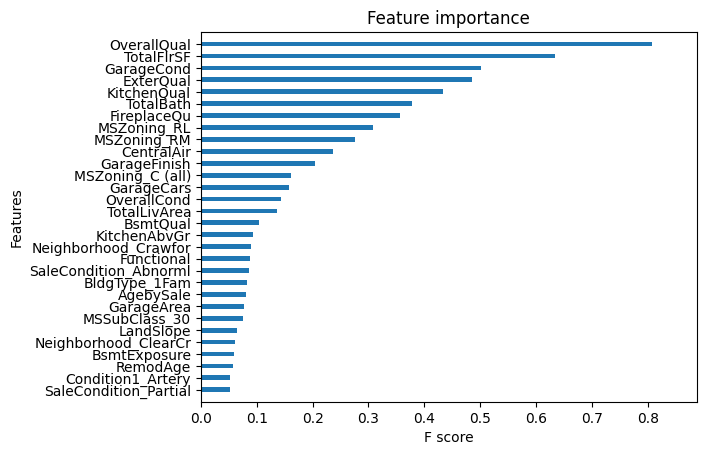

In [75]:
###### plot feature importance, importance_type = 'gain' ######################
##### same feature rank as manually plotting using model.feature_importances_ property
plot_importance(randsearch_xgbr.best_estimator_, importance_type = 'gain', height = 0.4,
                max_num_features = 30, grid = False, show_values = False); # top 30 most important features

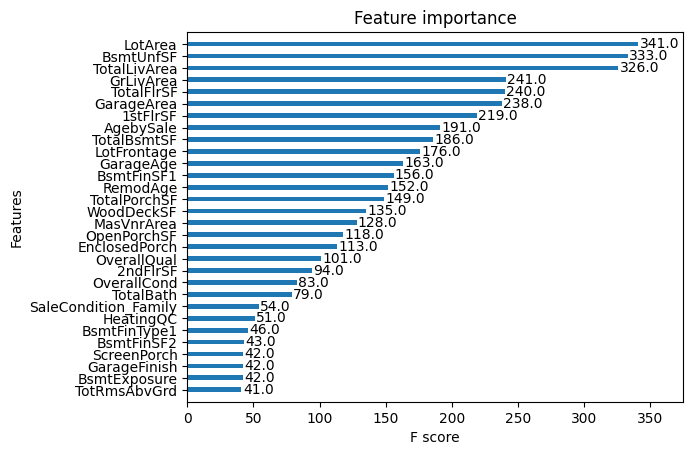

In [76]:
###### plot feature importance, importance_type = 'weight' ######################
plot_importance(randsearch_xgbr.best_estimator_, importance_type = 'weight', # default importance type of the function
                height = 0.4, max_num_features = 30, grid = False); # top 30 most important features

#### summary:
- selected most important feature sets are different when choosing different importance type 
- in feature importance plot with type 'gain', it shows that some of the most important features for XGBRegressor model building overlap with those for regularized regression models in feature importance analysis phase
- feature importance type 'weight' tends to assign higher importance to numerical and high cardinality features.


*back to [2. XGBRegressor Model](#2)*

<a name="2.2"></a>
## 2.2 More Focused Hyperparameter Tunning
- [hyperparameter tunning](#2.2.1)   
  use root_mean_squared_error (RMSE) scoring metric
- [feature importance visualization](#2.2.2)
- [model residual plots](#2.2.3)

<a name="2.2.1"></a>
### use `GridSearchCV` for a limited range of hyperparameter tunning

In [94]:
grid_values = {'subsample': [0.4, 0.45, 0.5, 0.55, 0.6], 
               'colsample_bytree': [0.3, 0.35, 0.4, 0.45, 0.5], 
               'min_child_weight': [8, 9, 10, 11, 12]}

In [95]:
%%time
xgbr_custom = XGBRegressor(booster = 'gbtree',
                           gamma = 0.1,
                           learning_rate = 0.1,
                           max_depth = 3,
                           n_estimators = 1200,
                           random_state = 0)

gridsearch_xgbr = GridSearchCV(xgbr_custom, param_grid = grid_values, cv = 3,
                               scoring = 'neg_root_mean_squared_error', verbose = 1)
gridsearch_xgbr.fit(X_train, y_train)

Fitting 3 folds for each of 125 candidates, totalling 375 fits
CPU times: total: 1h 48min 31s
Wall time: 14min 59s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.1, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1...
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    n_estimators=1200, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=0, ...),
             param_grid={'colsample_bytree': [0.3, 0.35, 0.4, 0.45, 0.5],
                         'min_child_weight': [8, 9, 10, 11, 12],
                         'subsample': [0.4, 0.45, 0.5, 0.55, 0.6]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [96]:
display_model_info(model = gridsearch_xgbr, mdl_str = 'XGBRegressor with GridSearchCV', 
                   score_metric = 'neg_root_mean_squared_error', X_test = X_test, y_test = y_test)


Model: XGBRegressor with GridSearchCV
Scoring Metric: neg_root_mean_squared_error
--------------------
best parameter achieved by parameter-search model:

{
  "colsample_bytree": 0.4,
  "min_child_weight": 8,
  "subsample": 0.6
}

number of features with non-zero feature importance value: 92 out of 203

best neg_root_mean_squared_error score achieved by parameter-search model:-0.12491807606164602

root_mean_squared_error score on test set:0.10668830378257653


<a name="2.2.2"></a>
### feature importance visualization

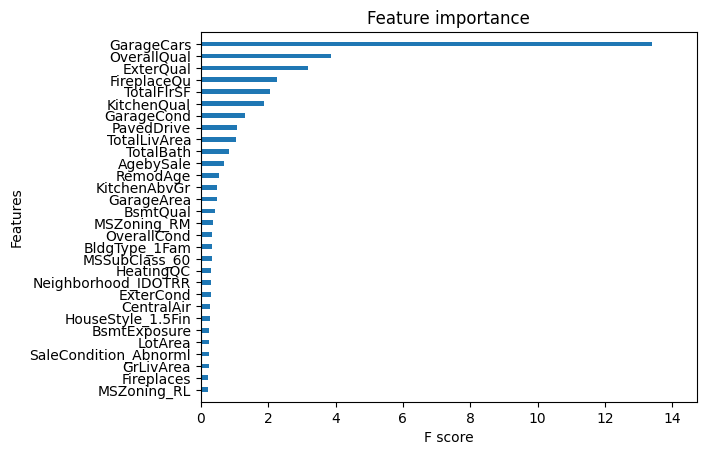

In [97]:
###### plot feature importance, importance_type = 'gain' ######################
plot_importance(gridsearch_xgbr.best_estimator_, importance_type = 'gain', height = 0.4,
                max_num_features = 30, grid = False, show_values = False); # top 30 most important features

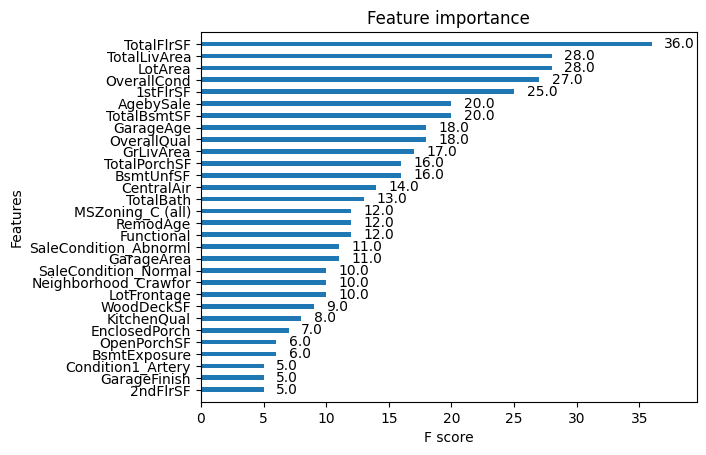

In [98]:
###### plot feature importance, importance_type = 'weight' ######################
plot_importance(gridsearch_xgbr.best_estimator_, importance_type = 'weight', # default importance type of the function
                height = 0.4, max_num_features = 30, grid = False); # top 30 most important features

#### summary:
- as model hyperparameters change, feature importance also changes
- selected most important feature sets are different when choosing different importance type 
- in feature importance plot with type 'gain', it shows that feature `GarageCars` takes a key role in model building and its feature importance value is much higher than other features

<a name="2.2.3"></a>
### model residual plots

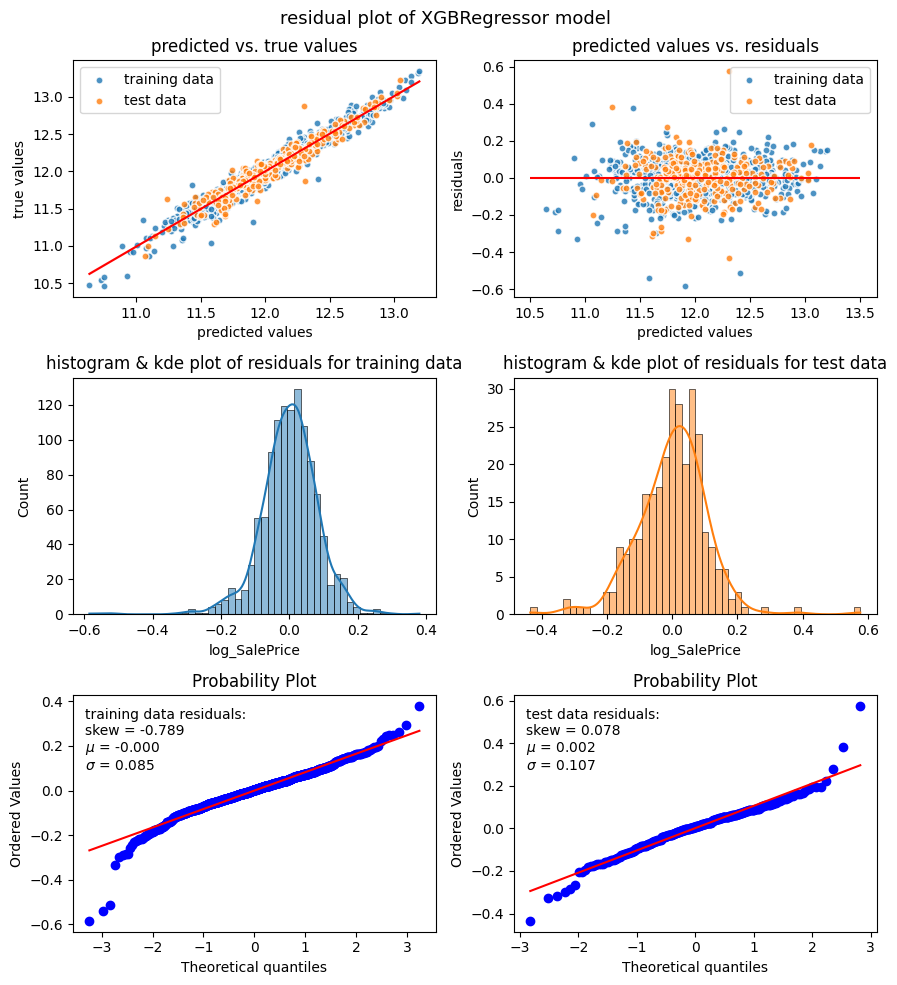

In [103]:
plot_resid(model = gridsearch_xgbr, mdl_str = 'XGBRegressor')

#### summary:
- 1nd picture of residual plot shows that predicted values match well with true target values  
- 2nd picture of residual plot shows that residuals seem to be randomly distributed and randomly  
  scattered around the centerline for both training and test data  
- the randomness and normality of residual distribution can be further confirmed with the histogram  
  and QQ-plot, which both show that the model is fitted properly
- this means the model is able to generalize well and make reasonably reliable house sale price predictions

  
*back to [2. XGBRegressor Model](#2)*      
*back to [content outline](#0)*

<a name="3"></a>
# 3. Neural Network Model
**use tensorflow package**
- [3.1 Model 1](#3.1) with 3 hidden layers
- [3.2 Model 2](#3.2) with 2 hidden layers

<a name="3.1"></a>
## 3.1 Model 1
#### 3 hidden layers
- use root_mean_squared_error (RMSE) scoring metric, defined by function `root_mean_squared_error`
- [plot training loss history](#3.1.1)

In [132]:
tf.random.set_seed(1234) # for consistent results
model_1 = Sequential(
    [
        tf.keras.Input(shape=(X_main_pro.shape[1],)),  #specify input shape
        Dense(50, activation = 'relu',   name = "L1"),
        Dense(25, activation = 'relu',   name = "L2"),
        Dense(50, activation = 'relu',   name = "L3"),
        Dense(1, activation = 'linear',  name = "L4")
        
    ], name = "model_1" 
)

In [133]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 50)                10200     
                                                                 
 L2 (Dense)                  (None, 25)                1275      
                                                                 
 L3 (Dense)                  (None, 50)                1300      
                                                                 
 L4 (Dense)                  (None, 1)                 51        
                                                                 
Total params: 12,826
Trainable params: 12,826
Non-trainable params: 0
_________________________________________________________________


In [134]:
%%time
model_1.compile(
    loss=root_mean_squared_error,
    metrics = [tf.keras.metrics.RootMeanSquaredError()],
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
)

history_1 = model_1.fit(
    X_train, 
    y_train,
    validation_split = 0.20,
    batch_size = 20,
    epochs = 100
)

Epoch 1/100
47/47 [==============================] - 1s 6ms/step - loss: 8.4197 - root_mean_squared_error: 8.8251 - val_loss: 1.9261 - val_root_mean_squared_error: 1.9297
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 1.1434 - root_mean_squared_error: 1.2150 - val_loss: 0.7673 - val_root_mean_squared_error: 0.7791
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.7143 - root_mean_squared_error: 0.7290 - val_loss: 0.5927 - val_root_mean_squared_error: 0.6037
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.5485 - root_mean_squared_error: 0.5616 - val_loss: 0.4685 - val_root_mean_squared_error: 0.4778
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4323 - root_mean_squared_error: 0.4446 - val_loss: 0.4466 - val_root_mean_squared_error: 0.4546
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.3631 - root_mean_squared_error: 0.3711 - val_loss: 0.3253 - val_root_m

Epoch 49/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0816 - root_mean_squared_error: 0.0852 - val_loss: 0.1487 - val_root_mean_squared_error: 0.1543
Epoch 50/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0812 - root_mean_squared_error: 0.0830 - val_loss: 0.1851 - val_root_mean_squared_error: 0.1906
Epoch 51/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0890 - root_mean_squared_error: 0.0921 - val_loss: 0.1458 - val_root_mean_squared_error: 0.1501
Epoch 52/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0752 - root_mean_squared_error: 0.0782 - val_loss: 0.1464 - val_root_mean_squared_error: 0.1521
Epoch 53/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0797 - root_mean_squared_error: 0.0836 - val_loss: 0.1459 - val_root_mean_squared_error: 0.1499
Epoch 54/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0794 - root_mean_squared_error: 0.0823 - val_loss: 0.1469 - val_

In [138]:
NN_score_summarize(history_1, model_1)


(training loss, validation loss) at the last epoch: (0.05930, 0.15597)

minimum validation loss appear at epoch: 56 out of 100

(training loss, validation loss) at epoch 56: (0.07806, 0.14406)

root_mean_squared_error score on test set: 0.16217069442790782


<a name="3.1.1"></a>
### plot training loss history

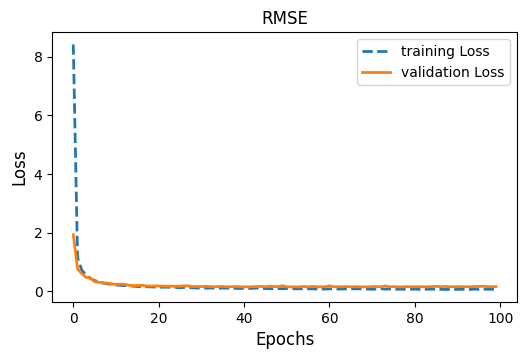

In [140]:
plot_loss_history(history_1.history['loss'], history_1.history['val_loss'])

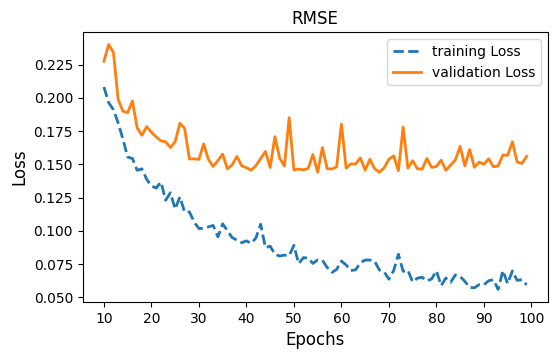

In [200]:
plot_loss_history(history_1.history['loss'], history_1.history['val_loss'], 10)

<a name="3.2"></a>
## 3.2 Model 2
#### 2 hidden layers
- use root_mean_squared_error (RMSE) scoring metric, defined by function `root_mean_squared_error`
- [plot training loss history](#3.2.1)
- [model residual plots](#3.2.2)

In [187]:
tf.random.set_seed(1234) # for consistent results
model_2 = Sequential(
    [
        tf.keras.Input(shape=(X_main_pro.shape[1],)),  #specify input shape
        Dense(30, activation = 'relu',   name = "L1"),
        Dense(12, activation = 'relu',   name = "L2"),
        Dense(1, activation = 'linear',  name = "L3")
        
    ], name = "model_2" 
)

In [188]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 30)                6120      
                                                                 
 L2 (Dense)                  (None, 12)                372       
                                                                 
 L3 (Dense)                  (None, 1)                 13        
                                                                 
Total params: 6,505
Trainable params: 6,505
Non-trainable params: 0
_________________________________________________________________


In [189]:
%%time
model_2.compile(
    loss=root_mean_squared_error,
    metrics = [tf.keras.metrics.RootMeanSquaredError()],
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
)

history_2 = model_2.fit(
    X_train, 
    y_train,
    validation_split = 0.20,
    batch_size = 20,
    epochs = 100
)

Epoch 1/100
47/47 [==============================] - 1s 6ms/step - loss: 10.9791 - root_mean_squared_error: 11.0045 - val_loss: 9.3659 - val_root_mean_squared_error: 9.3661
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 6.9924 - root_mean_squared_error: 7.1665 - val_loss: 3.8219 - val_root_mean_squared_error: 3.8243
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 1.7116 - root_mean_squared_error: 1.9246 - val_loss: 0.8998 - val_root_mean_squared_error: 0.9170
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8934 - root_mean_squared_error: 0.9147 - val_loss: 0.6691 - val_root_mean_squared_error: 0.6854
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6925 - root_mean_squared_error: 0.7115 - val_loss: 0.5489 - val_root_mean_squared_error: 0.5622
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.5738 - root_mean_squared_error: 0.5932 - val_loss: 0.4998 - val_root

Epoch 49/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1136 - root_mean_squared_error: 0.1181 - val_loss: 0.1383 - val_root_mean_squared_error: 0.1435
Epoch 50/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1152 - root_mean_squared_error: 0.1189 - val_loss: 0.1359 - val_root_mean_squared_error: 0.1403
Epoch 51/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1116 - root_mean_squared_error: 0.1158 - val_loss: 0.1397 - val_root_mean_squared_error: 0.1442
Epoch 52/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1101 - root_mean_squared_error: 0.1142 - val_loss: 0.1324 - val_root_mean_squared_error: 0.1366
Epoch 53/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1113 - root_mean_squared_error: 0.1147 - val_loss: 0.1316 - val_root_mean_squared_error: 0.1363
Epoch 54/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1080 - root_mean_squared_error: 0.1128 - val_loss: 0.1403 - val_

In [190]:
NN_score_summarize(history_2, model_2)


(training loss, validation loss) at the last epoch: (0.07811, 0.12197)

minimum validation loss appear at epoch: 97 out of 100

(training loss, validation loss) at epoch 97: (0.07993, 0.11733)

root_mean_squared_error score on test set: 0.12834229487558774


<a name="3.2.1"></a>
### plot training loss history

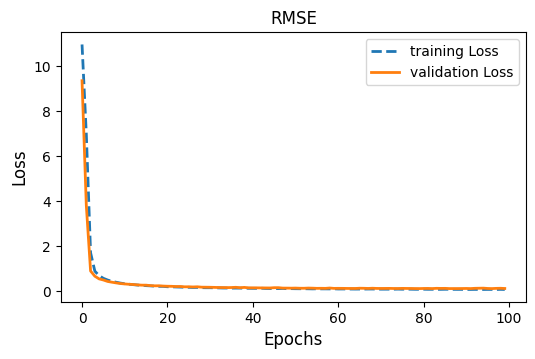

In [191]:
plot_loss_history(history_2.history['loss'], history_2.history['val_loss'])

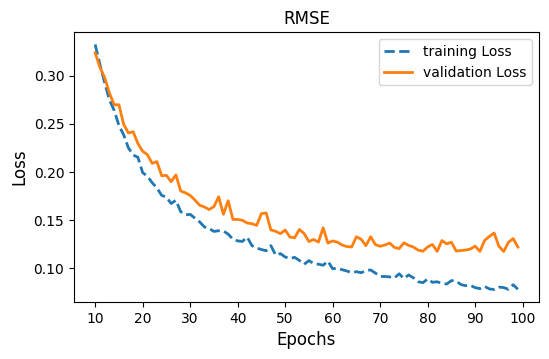

In [201]:
plot_loss_history(history_2.history['loss'], history_2.history['val_loss'], 10)

<a name="3.2.2"></a>
### model residual plots

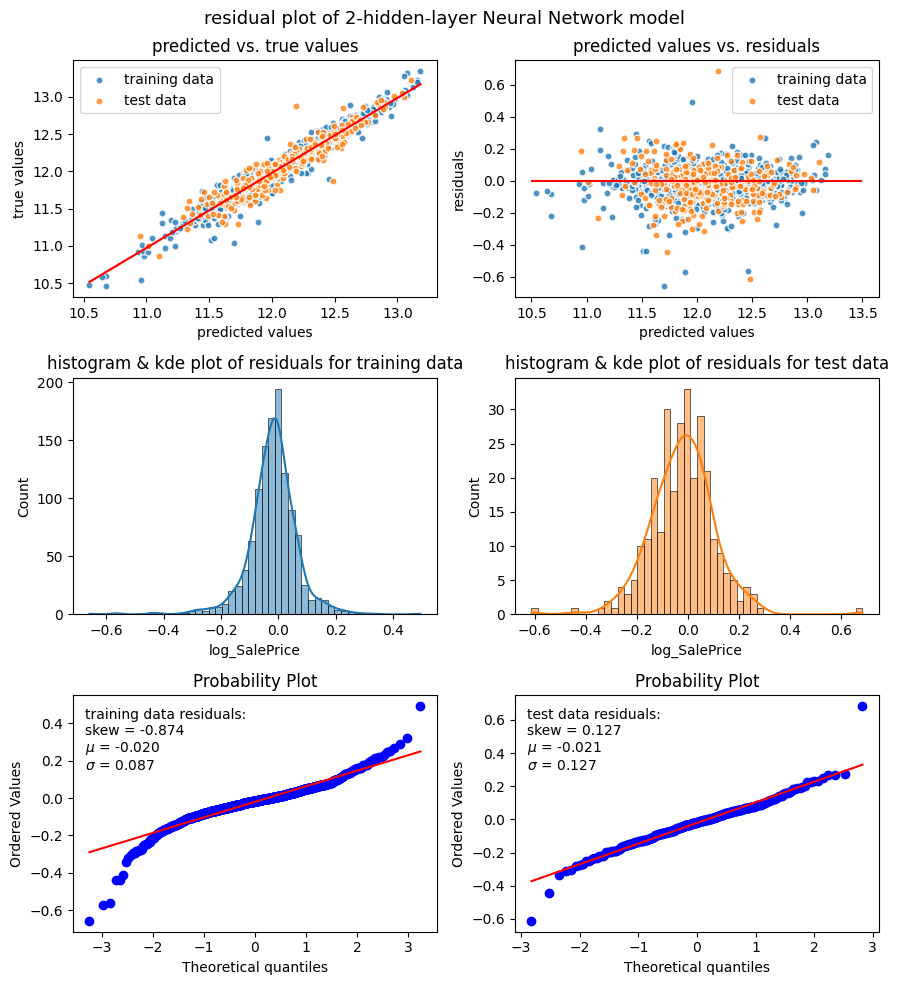

In [195]:
plot_resid(model = model_2, mdl_str = '2-hidden-layer Neural Network')

### summary:
- obviously training a neural network model with tensorflow for this house price prediction problem is much faster than training an XGBRegressor() model
- based on model training and evaluation process implemented above, more xgboost hyperparameter tunning and neural network structure adjustment iterations can be done repetatively to create more reliable machine learning models for better house price prediction
- to completely eliminate data leakage, the train_test_split step needs to be implemented before feature engineering pipeline, i.e., split data in train.csv to training and test data, then use pipeline to fit & transform training data, only transform test data
- more machine learning model types can be further explored for this prediction task

  
*back to [3. Neural Network Model](#3)*      
*back to [content outline](#0)*

### create submission file
**Finally, function `create_sub_file()` can be used to generate submission file for this kaggle competition.**

In [196]:
create_sub_file(model = model_2, file_name = 'nn_2.csv')

*back to [content outline](#0)*